Texting
========

You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)
import scipy.stats as stats

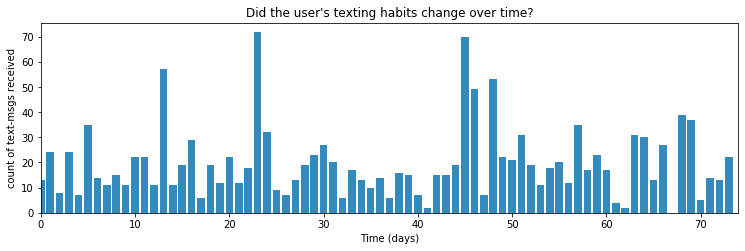

In [2]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)

figsize(12.5, 3.5)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [3]:
import pymc3 as pm

with pm.Model() as model:
    lambda_1 = pm.Normal('lambda_1', 20, 10)
    lambda_2 = pm.Normal('lambda_2', 20, 10)
    tau = pm.DiscreteUniform("tau", lower=10, upper=60)
    
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)
    trace = pm.sample(10000, tune=1000, chains=2)

INFO (theano.gof.compilelock): Waiting for existing lock by process '46454' (I am process '46483')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/max/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '46454' (I am process '46483')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/max/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '46454' (I am process '46483')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/max/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '46519' (I am process '46483')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/max/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.4-64/l

In [4]:
pm.summary(trace)

/Users/max/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lambda_1,17.784641,0.636706,0.004586,16.573494,19.070798,20132.763500,0.999969
lambda_2,22.727923,0.890966,0.006483,20.969572,24.444439,17130.930831,1.000123
tau,44.317250,0.802747,0.012842,43.000000,45.000000,3226.565496,1.000712


In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators.

In [5]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/Users/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


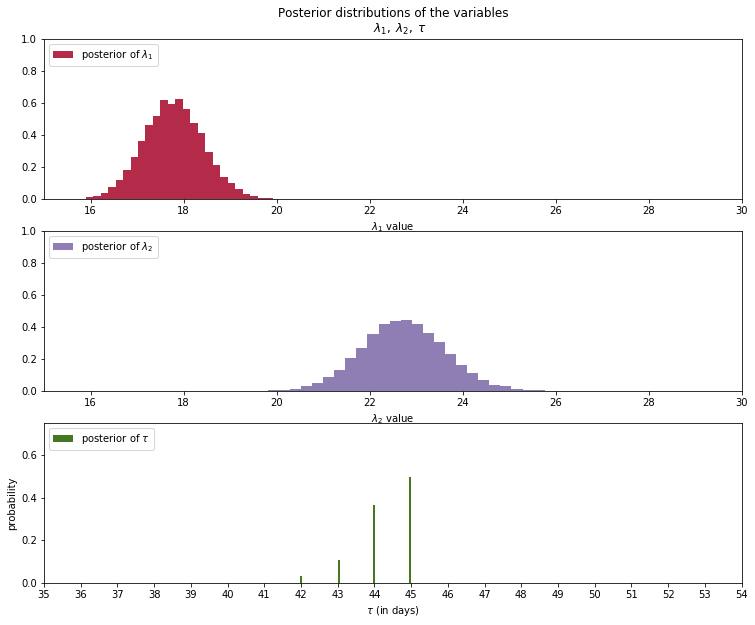

In [6]:
figsize(12.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

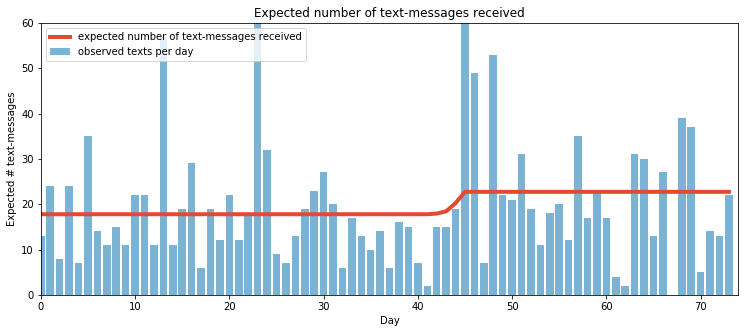

In [7]:
figsize(12.5, 5)
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution).